## 2. Марковский процесс принятия решения (markov decison process)

### Задание
#### 1. Приведите жизненный пример марковского процесса принятия решения (это может быть какаю-нибудь игра и т.п.).
Очень простой пример - шахматы. Конечное, пусть и очень большое, количество состояний $S$, конечное множество действий $ A \subset S \times S$. Среда - наш противник - отвечает вполне себе случайно. Если рассматривать среду именно как противника, то она, конечно, отдаёт сильное предпочтение тем действиям, которые она считает выигрышными. Награда для каждого допустимого действия из $\; S \times A \;$ нулевая за исключением последнего хода, по результатам которого присуждается награда $\pm 1$. Кроме того, очевидно, что для принятия решения информация о предыдущих состояниях нерелевантна. Таким образом, принятие решения в шахматах можно смоделировать с помощью марковского процесса.
#### 2. Можете ли вы привести пример игры, где принятие решения нельзя смоделировать с помощью марковского процесса?
Крестики-нолики на бесконечной доске не могут быть смоделированы хотя бы из-за бесконечности (в частности, континуальности) множества состояний $S$.
#### 3. Выведите следующие значения через $p(s_{t+1}, r_{t+1}|s_t, a_t)$, для простоты все распределения можно считать дискретными
  * $r(s_{t}, a_{t}) = \mathbb{E}[R_{t+1}|S_t = s_t, A_t = a_t]$ - средняя награда за действие $a_t$ в $s_t$ 
  * $p(s_{t+1} | s_t, a_t) = \Pr\{S_{t+1} = s_{t+1} | S_t = s_t, A_t = a_t \}$ - вероятность попасть в $s_{t+1}$ из $s_t$, сделав $a_t$.
  * $r(s_t, a_t, s_{t+1}) = \mathbb{E}[R_{t+1}|S_{t+1} = s_{t+1}, S_t = s_t, A_t = a_t]$ - средняя награда при переезде из $s_t$ в $s_{t+1}$, сделав $a_t$.

$r(s_{t}, a_{t}) = \mathbb{E}[R_{t+1}|S_t = s_t, A_t = a_t] = \sum_{s,r} r \cdot p(s, r \;|\; s_t, a_t)$

$p(s_{t+1} | s_t, a_t) = \Pr\{S_{t+1} = s_{t+1} | S_t = s_t, A_t = a_t \} = \sum_{r} p(s_{t+1}, r \;|\; s_t, a_t)$

$r(s_t, a_t, s_{t+1}) = \mathbb{E}[R_{t+1}|S_{t+1} = s_{t+1}, S_t = s_t, A_t = a_t] = \sum_{r} r \cdot p(s_{t+1}, r \;|\; s_t, a_t)$



### Смоделируем среду:

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage.filters import gaussian_filter1d


def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

### Построим такую модель:
$|S| = 100, \forall s \in S \; A_s = A, |A| = 20$

$ \forall s \in S, a \in A: \; p(r \; | \; s, a) \sim \mathcal{N}(m_{s,a}, 1), \; m_{s,a} \sim \mathcal{N}(0, 1)$

Распределение $p(s' \; | \; s, a)$ задаёт плотную матрицу

Случайные величины $s', r$ независимы

In [144]:
class Environment:
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions
        self.reward_means = np.random.normal(0, 16, size=(states, actions))
        self.reward_means[1] = 50
        self.reward_means[2] = -50
        transitions = np.random.randint(0, 2, size=(states, actions, states), dtype='int8')
        transitions[:, :, 0] += 1 - transitions.max(2)
        self.transition_probas = np.random.random_sample((states, actions, states)).astype('float64') * transitions
        for state in self.transition_probas:
            for action in state:
                if np.absolute(action).sum() < 0.01:
                    action = np.ones(states)
                action /= action.sum()
    
    def step(self, state, action):
        return (np.random.choice(self.states, p=self.transition_probas[state, action]),
            np.random.normal(self.reward_means[state, action], 4))

In [145]:
class PolicyIterationStrategy:
    def __init__(self, env, discount):
        self.env = env
        self.discount = discount
        self.policy = np.ones((env.states, env.actions))
        self.policy /= env.actions
    def learn(self):
        self.state_values = np.random.randn(self.env.states)
        self.state_action_values = np.zeros((self.env.states, self.env.actions))
        i = 0
        while True:
            while True:
                epsilon = 0
                for state in range(self.env.states):
                    old_value = self.state_values[state]
                    val_sum = 0
                    for action in range(self.env.actions):
                        action_sum = 0
                        for new_state in range(self.env.states):
                            action_sum += self.env.transition_probas[state, action, new_state] * \
                                (self.env.reward_means[state, action] + \
                                    self.discount*self.state_values[new_state])
                        val_sum += self.policy[state, action] * action_sum
                    self.state_values[state] = val_sum
                    epsilon = max(epsilon, abs(old_value - self.state_values[state]))
                i += 1
                if epsilon < 0.02: # random value, should be checked
                    break
                
            stable = True    
            for state in range(self.env.states):
                comp_values = self.state_action_values[state]
                old_best = np.argwhere(comp_values == comp_values.max())
                for action in range(self.env.actions):
                    action_sum = 0
                    for new_state in range(self.env.states):
                        action_sum += self.env.transition_probas[state, action, new_state] * \
                            (self.env.reward_means[state, action] + \
                                self.discount*self.state_values[new_state])
                    self.state_action_values[state, action] = action_sum
                comp_values = self.state_action_values[state]
                best = np.argwhere(comp_values == comp_values.max())
                self.policy[state] = 0
                self.policy[state][best] = 1
                self.policy[state] /= self.policy[state].sum()
                if not np.array_equal(old_best, best):
                    stable = False
            if stable:
                break
        return i
                    
                
    def choose(self, state):
        return np.random.choice(self.env.actions, p=self.policy[state])
    

class ValueIterationStrategy:
    def __init__(self, env, discount):
        self.env = env
        self.discount = discount
        self.policy = np.ones((env.states, env.actions))
        self.policy /= env.actions
    def learn(self):
        self.state_values = np.random.randn(self.env.states)
        self.state_action_values = np.zeros((self.env.states, self.env.actions))
        i = 0
        while True:
            epsilon = 0
            for state in range(self.env.states):
                old_value = self.state_values[state]
                max_val = -1e20
                for action in range(self.env.actions):
                    action_sum = 0
                    for new_state in range(self.env.states):
                        action_sum += self.env.transition_probas[state, action, new_state] * \
                            (self.env.reward_means[state, action] + \
                                self.discount*self.state_values[new_state])
                    max_val = max(max_val, action_sum)
                self.state_values[state] = max_val
                epsilon = max(epsilon, abs(old_value - self.state_values[state]))
            i += 1
            if epsilon < 0.02: # random value, should be checked
                break
                
        for state in range(self.env.states):
            res = np.zeros(self.env.actions)
            for action in range(self.env.actions):
                action_sum = 0
                for new_state in range(self.env.actions):
                    for new_state in range(self.env.states):
                        action_sum += self.env.transition_probas[state, action, new_state] * \
                            (self.env.reward_means[state, action] + \
                                self.discount*self.state_values[new_state])
                res[action] = action_sum
            best = np.argwhere(res == res.max())
            self.policy[state] = 0
            self.policy[state][best] = 1
            self.policy[state] /= self.policy[state].sum()
        
        return i
                
    def choose(self, state):
        return np.random.choice(self.env.actions, p=self.policy[state])
    
class RandomStrategy:
    def __init__(self, env, discount):
        self.env = env
        self.discount = discount
        self.policy = np.ones((env.states, env.actions))
        self.policy /= env.actions
    def learn(self):
        return 0
    def choose(self, state):
        return np.random.choice(self.env.actions, p=self.policy[state])

In [146]:
class MarkovPlayer:
    def __init__(self, states, actions, steps, strategy_class, discount):
        self.states = states
        self.actions = actions
        self.strategy_class = strategy_class
        self.steps = steps
        self.discount = discount
    def evaluate(self, games=1, progressbar=True,hold=False, show=True,
                 color='b', label=' '):
        rewards = np.zeros(self.steps)
        env = global_env
        if progressbar:
            games_range = log_progress(range(games), every=1)
        else:
            games_range = range(games)
        avg_time = 0
        for game in games_range:
            state = 0
            self.state = state
#             env = Environment(self.states, self.actions)
            strategy = self.strategy_class(env, self.discount)
            self.strategy = strategy
            avg_time += strategy.learn()
            for i in range(self.steps):
                state, rewards[i] = env.step(state, strategy.choose(state))
                self.state = state
        avg_time /= games
        discount = self.discount
        print(avg_time, 'steps to converge')
        for i in range(1, self.steps):
            rewards[i] = rewards[i-1] + discount * rewards[i]
            discount *= self.discount
        if show:
            x = np.arange(1, self.steps+1)
            plot_rewards = rewards
            plt.plot(x, plot_rewards, color, label=label)
            plt.title('Total reward', fontsize=16)
            if not hold:
                plt.show()
        return rewards.sum()

### Сравним эффективность и скорость сходимости алгоритмов:

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:13: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


0.0 steps to converge
===
139.8 steps to converge
===
81.0 steps to converge


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:19: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


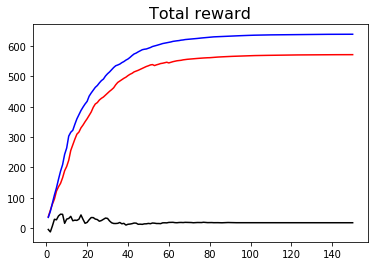

In [147]:
games_num = 10
steps = 150
discount = 0.95
states = 100
actions = 6
random_player = MarkovPlayer(states=states, actions=actions, steps=steps,
                           strategy_class=RandomStrategy, discount=discount)
policy_iteration_player = MarkovPlayer(states=states, actions=actions, steps=steps,
                           strategy_class=PolicyIterationStrategy, discount=discount)
value_iteration_player = MarkovPlayer(states=states, actions=actions, steps=steps,
                           strategy_class=ValueIterationStrategy, discount=discount)
global_env = Environment(100, 20)
plt.hold(True)
random_player.evaluate(games=games_num, hold=True, color='k')
print('===')
policy_iteration_player.evaluate(games=games_num, hold=True, color='r')
print('===')
value_iteration_player.evaluate(games=games_num, hold=True, color='b')
plt.hold(False)
plt.show()

Как можно заметить, оба алгоритма показывают схожие результаты, однако **value iteration strategy** сходится всё же побыстрее.

### Теперь посмотрим, как зависит значение $V_\gamma^*(s)$ для пяти произвольных состояний:

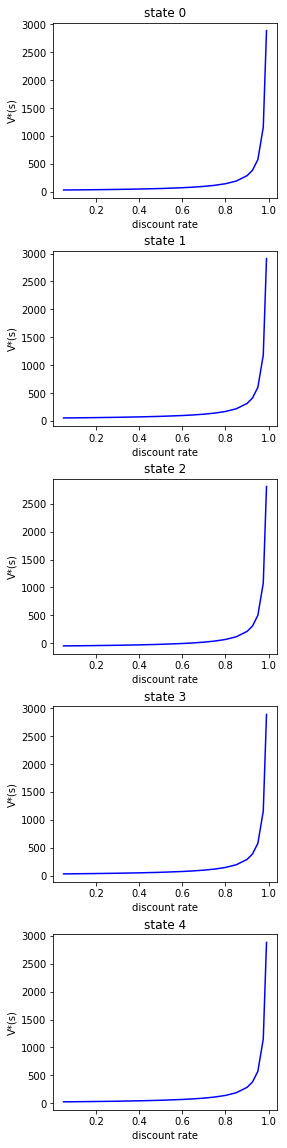

In [148]:
games_num = 10
states = 100
actions = 20
env = Environment(100, 20)
gammas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975, 0.99]
strategies = []
states = []
for gamma in log_progress(gammas):
    strategies.append(ValueIterationStrategy(env, gamma))
    strategies[-1].learn()
plt.figure(figsize=(4, 20))
for i in range(5):
    states.append([strategy.state_values[i] for strategy in strategies])
    plt.subplot(511 + i)
    plt.plot(gammas, states[i], 'b')
    plt.xlabel('discount rate')
    plt.ylabel('V*(s)')
    plt.title('state ' + str(i))
plt.subplots_adjust(hspace=0.3)
plt.show()

В целом такое поведение логично: к сожалению, вследствие плотности матрицы переходов переход из одного состояния в произвольное достаточно прост, поэтому алгоритмы смогут легко выбирать действия, приводящие к оптимальному результату, а значит, состояния слабо будут отличаться друг от друга. В данном случае сколь-либо заметная разница имеется лишь во втором и в первом состояниях, которые имеют искусственно выставленные контрастные награды с самого начала.

Такая зависимость ценностей от значения $\gamma$ тоже легко объяснима: при $\gamma \rightarrow 0$ ценности состояний, куда возможен переход из нашего состояния $s$, перестают как-либо влиять на его ценность и, соответственно, не увеличивают его, в то время как при $\gamma \rightarrow 1$ в качестве ценности состояния учитывается взвешенная суммарная ценность всех состояний, в которые можно попасть из текущего. Соответственно при максимизации алгоритмом выигрыша эта суммарная ценность будет только расти, что и показывает нам график